# Neural Style Transfer (using keras and tensorflow)

## Importing the important libraries

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from PIL import Image
import matplotlib.pyplot as plt

## Some important parameters

In [2]:
# Define the weights of the different loss components
style_wt = 1e6
content_wt = 1
total_variation_wt = 1e2

# Define the important functions

In [3]:
## Some of the utility functions

# Preprocessing the image to convert it into appropriate tensors for it to pass into the vgg19 model
def preprocess_img(img_path, gen_img_h, gen_img_w):
    img = keras.utils.load_img(img_path, target_size=(gen_img_h, gen_img_w))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

# Postprocessing the tensors back into a valid image
def postprocess_img(img_tensor, gen_img_h, gen_img_w):
    img = img_tensor.reshape((gen_img_h, gen_img_w, 3))
    # Remove zero-center by mean pixel (of the images of the ImageNet)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [4]:
## Loss functions and the gram matrix function

# Calculating the gram matrix of an image tensor (gram matrix --> feature-wise outer product)
def calc_gram_matrix(img_tensor):
    img_tensor = tf.transpose(img_tensor, (2, 0, 1))
    features = tf.reshape(img_tensor, (tf.shape(img_tensor)[0], -1))
    gram_matrix = tf.matmul(features, tf.transpose(features))
    return gram_matrix

# Calculating the style loss which helps to maintain the style of the style image in the generated image
def calc_style_loss(style_img, combination_img, gen_img_h, gen_img_w):
    style_gram_matrix = calc_gram_matrix(style_img)
    content_gram_matrix = calc_gram_matrix(combination_img)
    number_of_channels = 3
    size = gen_img_h * gen_img_w
    return tf.reduce_sum(tf.square(style_gram_matrix - content_gram_matrix)) / (4.0 * (number_of_channels**2) * (size**2))

# Calculating the content loss which helps to maintain the content of the base image in the generated image
def calc_content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

# Calculating the total variation loss which helps to keep the generated image locally coherent
def calc_total_variation_loss(img, gen_img_h, gen_img_w):
    a = tf.square(
        img[:, : gen_img_h - 1, : gen_img_w - 1, :] - img[:, 1:, : gen_img_w - 1, :]
    )
    b = tf.square(
        img[:, : gen_img_h - 1, : gen_img_w - 1, :] - img[:, : gen_img_h - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [5]:
## Load the VGG19 model for the feature extraction from the style and the base image

# Define a VGG19 model loaded with pre-trained ImageNet weights and do not include the classification head
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each layer
layer_outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Define a model that returns the activation values for every layer in VGG19 (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer_outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


In [6]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [7]:
# List of layers to be used for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Layer to be used for the content loss
content_layer_name = "block5_conv2"

In [8]:
## The main loss function which adds up all the losses according to their weights --> adjust the weights at the beginning part of the file

def compute_loss(combination_img, base_img, style_img, gen_img_h, gen_img_w):
    input_tensor = tf.concat([base_img, style_img, combination_img], axis=0)

    # Extract the features
    features = feature_extractor(input_tensor)

    # Initialize the loss using tf.zeros
    loss = tf.zeros(shape=())

    # Add the content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    content_loss = calc_content_loss(base_image_features, combination_features)
    loss += content_wt * content_loss

    # Add the style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss = calc_style_loss(style_features, combination_features, gen_img_h, gen_img_w)
        loss += (style_wt / len(style_layer_names)) * style_loss

    # Add the total variation loss
    total_variation_loss = calc_total_variation_loss(combination_img, gen_img_h, gen_img_w)
    loss += total_variation_wt * total_variation_loss
    return loss

In [33]:
## Define the function for the training

@tf.function
def compute_grads(combination_img, base_img, style_img, gen_img_h, gen_img_w):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_img, base_img, style_img, gen_img_h, gen_img_w)
    grads = tape.gradient(loss, combination_img)
    return grads

# Define the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 5.0)

# Define the training function
def train(base_img_path, style_img_path, iterations = 2000, checkpoint = 500, gen_img_h = 400): #the generated img width automatically adjusts itself according to the dimensions of the base img provided
    # Setting the dimensions of the generated picture
    width, height = keras.utils.load_img(base_img_path).size
    gen_img_w = int(width * gen_img_h / height)

    base_img = preprocess_img(base_img_path, gen_img_h, gen_img_w)
    style_img = preprocess_img(style_img_path, gen_img_h, gen_img_w)
    combination_img = tf.Variable(preprocess_img(base_img_path, gen_img_h, gen_img_w))

    for i in range(1, iterations + 1):
        grads = compute_grads(combination_img, base_img, style_img, gen_img_h, gen_img_w)
        optimizer.apply_gradients([(grads, combination_img)])

        if i % 100 == 0:
            print(f"Iteration {i} completed")

        if i % checkpoint == 0:
            img = postprocess_img(combination_img.numpy(), gen_img_h, gen_img_w)
            file_name = base_img_path.split('/')[-1].split('.')[0] + f"_{i}.png"
            keras.utils.save_img(file_name, img)
            print(f"The image at the {i} iteration is saved")

In [21]:
# Define a function to plot the generated image along with the base and style image

def plot_results(base_img_path, style_img_path, generated_img_path, figure_size=(12, 12)):
    base_img = Image.open(base_img_path)
    style_img = Image.open(style_img_path)
    generated_img = Image.open(generated_img_path)

    images = [base_img, style_img, generated_img]
    titles = ['Base image', 'Style image', 'Result']

    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

## Start the training

In [43]:
# Define the path to the base image and the style image here

base_img_path = '/content/kaneki.jpeg'
style_img_path = '/content/expressionism.jpg'

In [36]:
# start the training process
train(base_img_path, style_img_path)

Iteration 100 completed
Iteration 200 completed
Iteration 300 completed
Iteration 400 completed
Iteration 500 completed
Iteration 600 completed
Iteration 700 completed
Iteration 800 completed
Iteration 900 completed
Iteration 1000 completed
The image at the 1000  iteration is saved
Iteration 1100 completed
Iteration 1200 completed
Iteration 1300 completed
Iteration 1400 completed
Iteration 1500 completed
Iteration 1600 completed
Iteration 1700 completed
Iteration 1800 completed
Iteration 1900 completed
Iteration 2000 completed
The image at the 2000  iteration is saved


## Check the results

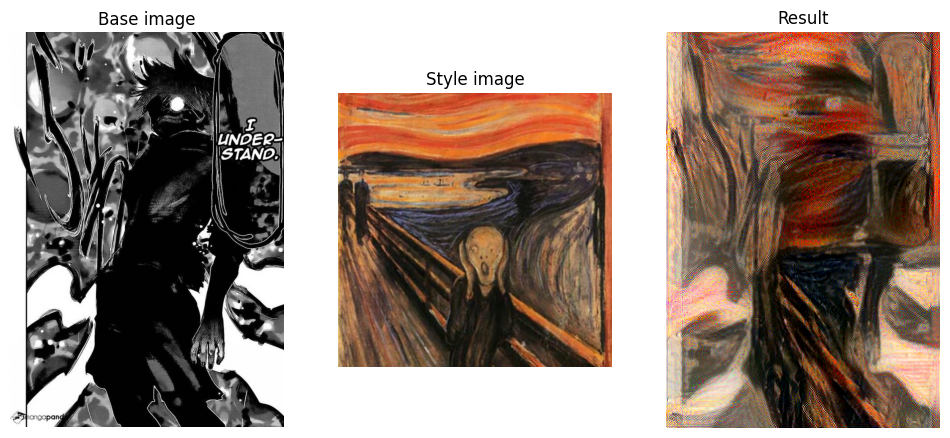

In [44]:
# Define the path to the generated image
generated_img_path = '/content/kaneki_2000.png'

plot_results(base_img_path, style_img_path, generated_img_path)